## 권철민 강사의 [개정판] 딥러닝 컴퓨터 비전 완벽 가이드에서 학습한 내용을 복습하는 내용입니다.

In [ ]:
# 내용 참고
# https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import torch
print(torch.__version__)

In [ ]:
!pip install torch==1.13.0+cu116 torchvision==0.14.0+cu116 --extra-index-url https://download.pytorch.org/whl/cu116

In [ ]:
# mmcv를 위해서 mmcv-full을 먼저 설치해야 함. 
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu116/torch1.13/index.html
# mmdetection 설치 
!git clone --branch 2.x https://github.com/open-mmlab/mmdetection.git
!cd mmdetection; python setup.py install

In [1]:
# 아래를 수행하기 전에 kernel을 restart 해야 함. 
from mmdet.apis import init_detector, inference_detector
import mmcv

/opt/conda/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


### KITTI Dataset 다운로드
* 작은 용량의 kiiti dataset을 다운하고 /kaggle/working 디렉토리에서 압축 해제

In [2]:
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2024-05-04 03:54:22--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 47.246.48.201, 47.246.48.202, 47.246.48.203, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|47.246.48.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: 'kitti_tiny.zip'

kitti_tiny.zip      100%[===================>]   6.60M  34.2MB/s    in 0.2s    

2024-05-04 03:54:22 (34.2 MB/s) - 'kitti_tiny.zip' saved [6918271/6918271]



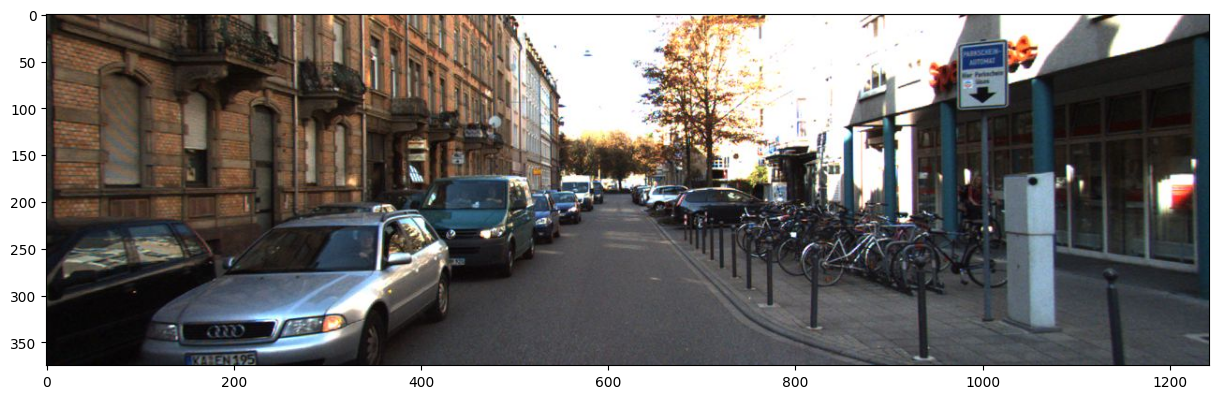

In [3]:
import matplotlib.pyplot as plt
import cv2

img = cv2.cvtColor(cv2.imread('/kaggle/working/kitti_tiny/training/image_2/000068.jpeg'), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15,10))
plt.imshow(img)

### KITTI DATA FORMAT 확인
* 첫 번째 칼럼은 해당 오브젝트의 클래스 명
* 5번째 ~ 8번째가 bouding box 정보다,

In [4]:
!cat /kaggle/working/kitti_tiny/training/label_2/000068.txt

'''
가장 왼쪽부터 type, truncated, occuluded, alpha, bbox, dimensions, location, rotation_y, score로 구성

type: car, van, truck, pedestrian, person_sitting, cyclist, tram, misc or dontcare
truncated: bbox가 이미지에서 벗어나는 정도를 의미 [0.0 ~ 1.0]
occluded: 객체가 가려진 정도를 의미 (0, 1, 2, 3: 가려진 정도를 나타내며, 높을수록 안보임)
alpha: 객체의 각도를 의미 [-ph. ~ ph.]
bbox: 객체를 감싸는 박스의 정보 (left, top, right, bottom)
'''

Car 0.25 0 1.94 69.26 200.28 435.08 374.00 1.46 1.62 4.04 -3.00 1.79 6.98 1.55
Car 0.80 1 2.26 0.00 209.20 198.59 374.00 1.46 1.58 3.72 -5.44 1.85 6.22 1.56
Cyclist 0.97 0 2.34 1210.28 199.77 1241.00 374.00 1.55 0.57 1.73 4.04 1.69 3.57 -3.14
Car 0.00 2 1.68 478.18 187.68 549.54 249.43 1.57 1.60 3.99 -2.73 2.03 20.96 1.55
Car 0.00 1 1.66 530.03 187.79 573.10 226.09 1.52 1.54 3.68 -2.53 2.20 31.50 1.58
Van 0.00 1 1.63 547.61 171.12 584.05 212.41 2.47 1.98 5.81 -2.79 2.41 46.44 1.57
Car 0.00 1 -0.16 667.74 182.35 790.82 230.38 1.62 1.65 4.14 4.19 1.99 25.95 0.00
Car 0.00 2 -0.11 657.37 184.48 763.34 221.64 1.55 1.66 4.47 4.35 2.10 32.00 0.02
Car 0.00 1 -0.01 637.45 180.34 714.44 212.34 1.69 1.76 4.12 3.59 2.12 39.79 0.08
Van 0.00 1 1.61 572.52 175.02 596.26 199.95 2.13 1.91 6.40 -2.28 2.36 65.43 1.57
Van 0.00 1 1.77 380.78 167.69 523.29 288.56 1.95 1.75 4.63 -2.89 1.90 14.05 1.57
Cyclist 0.00 1 1.09 958.95 167.55 1036.88 254.43 1.68 0.53 1.96 7.95 1.59 14.95 1.57


'\n가장 왼쪽부터 type, truncated, occuluded, alpha, bbox, dimensions, location, rotation_y, score로 구성\n\ntype: car, van, truck, pedestrian, person_sitting, cyclist, tram, misc or dontcare\ntruncated: bbox가 이미지에서 벗어나는 정도를 의미 [0.0 ~ 1.0]\noccluded: 객체가 가려진 정도를 의미 (0, 1, 2, 3: 가려진 정도를 나타내며, 높을수록 안보임)\nalpha: 객체의 각도를 의미 [-ph. ~ ph.]\nbbox: 객체를 감싸는 박스의 정보 (left, top, right, bottom)\n'

### KITTI annotation 파일들의 리스트들을 가지는 파일 확인
* kitti 데이터셋은 ms coco 데이터셋과 같이 하나의 annotation 파일을 갖는 구조라 한 파일 안에 train 데이터들의 정보가 들어 있음

In [5]:
!cat /kaggle/working/kitti_tiny/train.txt

000000
000001
000002
000003
000004
000005
000006
000007
000008
000009
000010
000011
000012
000013
000014
000015
000016
000017
000018
000019
000020
000021
000022
000023
000024
000025
000026
000027
000028
000029
000030
000031
000032
000033
000034
000035
000036
000037
000038
000039
000040
000041
000042
000043
000044
000045
000046
000047
000048
000049


### mmdetection의 middle annotation 포맷 변환, 해당 포맷은 텍스트로 변환하지 않고 바로 메모리 상의 list로 생성한다
* filename, width, height, ann을 key로 갖는 dictionary를 이미지 개수대로 갖는 list 생성
* filename: 이미지 파일명(디렉토리는 미포함)
* width, height: 각각 이미지 너비, 높이
* ann: bounding box와 label에 대한 정보를 갖는 dictionary
    * bboxes: 하나의 이미지에 있는 여러 obj들의 numpy array로, 4개의 좌표값을 갖고 해당 이미지에 n개 obj 있으면 shape는 (n,4)
    * labels: 하나의 이미지에 있는 여러 obj들의 label 정보를 담은 nunpy array. shape는 (n,)
    * bboxes_ignore: 학습에 사용되지 않고 무시하는 bboxes로 무시하는 bboxes의 개수가 k개면 shape는 (k,4)
    * labels_ignore: 학습에 사용되지 않고 무시하는 labels로 무시하는 obj가 k개면 shape는 (k,)

In [6]:
'''
mmdetection middle format 예시

[
    {
        'filename': 'a.jpg',
        'width': 1280,
        'height': 720,
        'ann': {
            'bboxes': <np.ndarray, float32> (n, 4),
            'labels': <np.ndarray, int64> (n, ),
            'bboxes_ignore': <np.ndarray, float32> (k, 4),
            'labels_ignore': <np.ndarray, int64> (k, ) (optional field)
        }
    },
    ...
]
'''

"\nmmdetection middle format 예시\n\n[\n    {\n        'filename': 'a.jpg',\n        'width': 1280,\n        'height': 720,\n        'ann': {\n            'bboxes': <np.ndarray, float32> (n, 4),\n            'labels': <np.ndarray, int64> (n, ),\n            'bboxes_ignore': <np.ndarray, float32> (k, 4),\n            'labels_ignore': <np.ndarray, int64> (k, ) (optional field)\n        }\n    },\n    ...\n]\n"

### kitti dataset middle format으로 변환하여 메모리 로드
* kitti tiny dataset을 위에 있는 middle type format으로 변경

In [7]:
# 원본 kitti dataset classes 중에서 4개만 사용

CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
cat2label = {k:i for i, k in enumerate(CLASSES)}
print(cat2label)
cat2label['Car']

{'Car': 0, 'Truck': 1, 'Pedestrian': 2, 'Cyclist': 3}


0

In [8]:
image_list = mmcv.list_from_file('/kaggle/working/kitti_tiny/train.txt')
image_list[:5]

['000000', '000001', '000002', '000003', '000004']

In [9]:
import copy
import os.path as osp
import cv2 

import mmcv
import numpy as np

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

# 반드시 아래 Decorator을 설정해야 한다. @DATASETS.register_module() 설정 시 force=True를 입력하지 않으면 Dataset 재등록 불가
# CumstomDataset 상속 받아서 
# DATASETS.register_module은 mmdetection/mmdet/dataset의 cumstom.py에서 확인하는데 config에서 들어온다
@DATASETS.register_module(force=True)
class KittyTinyDataset(CustomDataset):
    # CLASSES는 list, tuple 감싸는 방식은 상관없는데 이름은 무조건 대소문자 구분해서 CLASSES
    CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
    # det __init__(self)는 없는 이유가 CustomDataset 상속해서 사용하니까 따로 없는거다
    
    # data_root와 ann_file 경로 등은 config 파일에서 설정한 것을 읽어온다
    def load_annotations(self, ann_file):
        print('##### self.data_root:', self.data_root, 'self.ann_file:', self.ann_file, 'self.img_prefix:', self.img_prefix)
        print('### ann_file:', self.ann_file)
        cat2label = {k:i for i, k  in enumerate(self.CLASSES)}
        image_list = mmcv.list_from_file(self.ann_file)
        # fotmat middle data를 담을 list 객체
        data_infos = []
        
        for image_id in iamge_list:
            # filename 절대경로로 구해서 opencv에 넣어야 한다
            filename = '{0:}/{1:}.jpeg'.format(self.img_prefix, image_id)
            # 원본 이미지의 너비, 높이를  image로 직접 로드하여 구현
            image = cv2.imread(filename)
            height, width = image.shape[:2]
            # 개별 image의 annotation 정보 저장용 dict 생성. key값과 filename에는 image의 파일명만 들어간다
            data_info = {'filename': str(image_id) + '.jpeg',
                        'width':width, 'height':height}
            # 개별 annotation이 있는 서브 디렉토리의 prefix 변환
            label_prefix = self.img_prefix.replace('image_2', 'label_2')
            # 개별 annotation 파일을 1개 line 단위로 읽어서 list 로드
            lines = mmcv.list_from_file(ops.join(label_prefix, str(image_id) + '.txt'))
            
            # 전체 lines를 개별 line별 공백 레벨로 parsing하여 다시 list로 적용
            # ann 정보는 numpy array로 저장되나 텍스트 처리나 데이터 가공이 list가 편해 일차적으로 list로 변환 
            content = [line.strip.split(' ') for line in lines]
            bbox_names = [x[0] for x in content]
            # bbox 좌표를 저장
            bboxes = [[float(info) for info in x[4:8]] for x in content]
            
            # 클래스명이 해당 사항이 있는 대상 filtering out
            gt_bboxes = []
            gt_labels = []
            gt_bboxes_ignore = []
            gt_labels_ignore = []
            
            for bbox_name, bbox in zip(bbox_names, bboxes):
                # bbox_name이 클래스명에 있는 경우 없는 경우 분류
                if bbox_name in cat2label:
                    gt_bboxes.append(bbox)
                    # gt_labels에는 class id를 입력
                    gt_labels.append(cat2label[bbox_name])
                else:
                    gt_bboxes_ignore.append(bbox)
                    gt_labels_ignore.append(-1)
                # 개별 image별 annotation 정보를 갖는 dict 생성. 해당 dict의 value 값은 모두 np.array임
                data_anno = {
                  'bboxes': np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
                  'labels': np.array(gt_labels, dtype=np.longlong),
                  'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
                  'labels_ignore': np.array(gt_labels_ignore, dtype=np.longlong)
                }
            # image에 대한 메타 정보를 가지는 data_info Dict에 'ann' key값으로 data_anno를 value로 저장
            data_info.update(ann=data_anno)
            data_infos.append(data_info)
            
        return data_infos
    
    def get_ann_info(self, idx):
        return self.data_infos[idx]['ann']

In [14]:
!cd mmdetection; mkdir checkpoints
!wget -O /kaggle/working/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

--2024-05-04 04:00:43--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.246.48.197, 47.246.48.198, 47.246.48.199, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|47.246.48.197|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: '/kaggle/working/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

/kaggle/working/mmd 100%[===================>] 159.54M  89.4MB/s    in 1.8s    

2024-05-04 04:00:46 (89.4 MB/s) - '/kaggle/working/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth' saved [167287506/167287506]



In [15]:
!ls -lia /kaggle/working/mmdetection/checkpoints

total 163376
1050943 drwxr-xr-x  2 root root      4096 May  4 04:00 .
1048584 drwxr-xr-x 19 root root      4096 May  4 04:00 ..
1050944 -rw-r--r--  1 root root 167287506 Nov  2  2021 faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


In [17]:
config_file = '/kaggle/working/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/kaggle/working/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [18]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [21]:
# config 설정 시 data는 절대경로로 지정하는 것을 추천

from mmdet.apis import set_random_seed

# dataset에 대한 환경 파라미터 설정
cfg.dataset_type = 'KittyTinyDataset'
cfg.data_root = '/kaggle/working/kitti_tiny/'

# train, val, test dataset에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정
# train 데이터 만들 땐 아래 config 활용
cfg.data.train.type = 'KittyTinyDataset'
cfg.data.train.data_root = '/kaggle/working/kitti_tiny/'  # 이 구문이 없으면 자동으로 cfg.data_root 내용이 오버라이드 된다
# ann 정보는 label_2 파일에 있는데 ann 정보는 한 파일에 있어야 해서 train txt로 설정
# 구체적인 파일은 data_root와 결합해서 사용하므로 '/' 없이 파일명만 기입
cfg.data.train.ann_file = 'train.txt'
# img_prefix는 여러개의 이미지 파일이라 dir 형식으로 지정
# img_prefix는 결과적으로 data_root와 img_prefix 변수를 concate하여 만든다
cfg.data.train.img_prefix = 'training/image_2'

cfg.data.val.type = 'KittyTinyDataset'
cfg.data.val.data_root = '/kaggle/working/kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

cfg.data.test.type = 'KittyTinyDataset'
cfg.data.test.data_root = '/kaggle/working/kitti_tiny/'
cfg.data.test.ann_file = 'val.txt'
cfg.data.test.img_prefix = 'training/image_2'

# class의 개수 수정
cfg.model.roi_head.bbox_head.num_classes = 4
# pretrained 모델
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉토리 설정
cfg.work_dir = './tutorial_exps'

# 학습률 변경 환경 파라미터 설정
# the original learning rate is set for 8-GPU training
# it's divided by 8 since we only use one GPU
cfg.optimizer.lr = 0.02 / 8

cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# config 수행 시마다 policy값이 없어지는 bug로 인하여 설정. 
# 종종 cfg.lr_config.policy 값이 없다고 나오는 경우 대비
cfg.lr_config.policy = 'step'

# Change the evaluation metric since we use customized dataset.
cfg.evaluation.metric = 'mAP'
# we can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic = False)
cfg.gpu_ids = range(1)

# we can initailize the logger for training and habe a look
# at the final config used for training
print(f'Config\n{cfg.pretty_text}')


# 'ConfigDict' object has no attribute 'device' 오류 방지를 위한 설정. 
cfg.device='cuda'

Config
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_we